<a href="https://colab.research.google.com/github/Devansh-0/COVID-19/blob/main/Fashion_MINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GoogleNet** - **FASHION MNIST**



In [ ]:
import torch.nn as nn
import torch
import math

class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        return self.relu(x)


class Inception(nn.Module):

    def __init__(self, in_channels, ch1x1, ch3x3reduce, ch3x3, ch5x5reduce, ch5x5, pool_proj):

        super(Inception, self).__init__()

        conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3reduce, kernel_size=1),
            conv_block(ch3x3reduce, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5reduce, kernel_size=1),
            conv_block(ch5x5reduce, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogLeNet, self).__init__()
        conv_block, inception_block = BasicConv2d, Inception

        self.conv1 = conv_block(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3)

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv3 = conv_block(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x, labels=None):
        x = self.conv1(x)
        x = self.maxpool1(x)
        # print(x.shape)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        # print(x.shape)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        # print(x.shape)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        # print(x.shape)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        # print(x.shape)
        x = torch.flatten(x, 1)
        # N x 1024
        # print(x.shape)
        x = self.dropout(x)
        logits = self.fc(x)
        # N x 1000 (num_classes)
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(reduction='mean')
            loss = loss_fct(logits, labels)
            return loss, logits
        else:
            return logits


In [ ]:
import torchvision


def load_dataset(batch_size, resize=None):
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize, interpolation=1))
    trans.append(torchvision.transforms.ToTensor())
    transform = torchvision.transforms.Compose(trans)
    train_loader = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',
                                                     train=True, download=True,
                                                     transform=transform)
    test_loader = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',
                                                    train=False, download=True,
                                                    transform=transform)
    train_iter = torch.utils.data.DataLoader(train_loader,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=1)
    test_iter = torch.utils.data.DataLoader(test_loader,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=1)
    return train_iter, test_iter


class MyModel:
    def __init__(self,
                 batch_size=128,
                 epochs=5,
                 learning_rate=0.0003):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.model = GoogLeNet(10)

    def train(self):
        train_iter, test_iter = load_dataset(batch_size=self.batch_size, resize=96)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)  
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)
        for epoch in range(self.epochs):
            for i, (x, y) in enumerate(train_iter):
                x, y = x.to(device), y.to(device)
                loss, logits = self.model(x, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() 
                if i % 50 == 0:
                    acc = (logits.argmax(1) == y).float().mean()
                    print("Epochs[{}/{}]---batch[{}/{}]---acc {:.4}---loss {:.4}".format(
                        epoch + 1, self.epochs, i, len(train_iter), acc, loss.item()))
            self.model.eval()  # 切换到评估模式
            print("Epochs[{}/{}]--acc on test {:.4}".format(epoch + 1, self.epochs,
                                                            self.evaluate(test_iter, self.model, device)))
            self.model.train()  # 切回到训练模式

    @staticmethod
    def evaluate(data_iter, model, device):
        with torch.no_grad():
            acc_sum, n = 0.0, 0
            for x, y in data_iter:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                acc_sum += (logits.argmax(1) == y).float().sum().item()
                n += len(y)
            return acc_sum / n


if __name__ == '__main__':
    model = MyModel()
    model.train()



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw

Epochs[1/5]---batch[0/469]---acc 0.1406---loss 2.301
Epochs[1/5]---batch[50/469]---acc 0.1953---loss 1.812
Epochs[1/5]---batch[100/469]---acc 0.3516---loss 1.438
Epochs[1/5]---batch[150/469]---acc 0.5156---loss 1.144
Epochs[1/5]---batch[200/469]---acc 0.5078---loss 1.229
Epochs[1/5]---batch[250/469]---acc 0.5---loss 1.131
Epochs[1/5]---batch[300/469]---acc 0.6328---loss 0.9165
Epochs[1/5]---batch[350/469]---acc 0.7031---loss 0.8829
Epochs[1/5]---batch[400/469]---acc 0.7266---loss 0.7474
Epochs[1/5]---batch[450/469]---acc 0.75---loss 0.6978
Epochs[1/5]--acc on test 0.7137
Epochs[2/5]---batch[0/469]---acc 0.7656---loss 0.7882
Epochs[2/5]---batch[50/469]---acc 0.7422---loss 0.7724
Epochs[2/5]---batch[100/469]---acc 0.7734---loss 0.6187
Epochs[2/5]---batch[150/469]---acc 0.7891---loss 0.6012
Epochs[2/5]---batch[200/469]---acc 0.8281---loss 0.5389
Epochs[2/5]---

## MNASNet with Fashion Mnist

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# transform = transforms.Compose(
#     [transforms.Resize((224, 224)),
#      transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
[transforms.ToTensor(),
 torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

mnasnet = models.mnasnet1_0(pretrained=True)
mnasnet.to(device)
print('')
# print(mnasnet)

cuda:0



In [ ]:
# def load_dataset(batch_size, resize=None):
#     trans = []
#     if resize:
#         trans.append(torchvision.transforms.Resize(size=resize, interpolation=1))
#     trans.append(torchvision.transforms.ToTensor())
#     transform = torchvision.transforms.Compose(trans)
#     train_loader = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',
#                                                      train=True, download=True,
#                                                      transform=transform)
#     test_loader = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',
#                                                     train=False, download=True,
#                                                     transform=transform)
#     train_iter = torch.utils.data.DataLoader(train_loader,
#                                              batch_size=batch_size,
#                                              shuffle=True,
#                                              num_workers=1)
#     test_iter = torch.utils.data.DataLoader(test_loader,
#                                             batch_size=batch_size,
#                                             shuffle=False,
#                                             num_workers=1)
#     return train_iter, test_iter

# train_iter, test_iter = load_dataset(32)

In [ ]:
for x, y in trainloader:
  print(x.shape)
  break

torch.Size([32, 3, 28, 28])


In [ ]:
# mnasnet.layers[0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
mnasnet.classifier[1].out_features = 10
# mnasnet

In [ ]:
# change the number of classes 
# mnasnet.classifier[0].out_features = 10
# freeze convolution weights
# for param in mnasnet.features.parameters():
#     param.requires_grad = False

In [ ]:
# optimizer
optimizer = optim.SGD(mnasnet.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    print('EPOCH:', epoch)
    train_epoch_loss, train_epoch_accuracy = fit(mnasnet, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(mnasnet, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')  

EPOCH: 0
Train Loss: 0.0524, Train Acc: 56.36
EPOCH: 1
Train Loss: 0.0411, Train Acc: 61.77
EPOCH: 2
Train Loss: 0.0369, Train Acc: 64.07
EPOCH: 3
Train Loss: 0.0349, Train Acc: 65.06
EPOCH: 4
Train Loss: 0.0340, Train Acc: 65.86
EPOCH: 5
Train Loss: 0.0332, Train Acc: 66.03
EPOCH: 6
Train Loss: 0.0329, Train Acc: 66.17
EPOCH: 7
Train Loss: 0.0326, Train Acc: 66.43
EPOCH: 8
Train Loss: 0.0322, Train Acc: 66.44
EPOCH: 9
Train Loss: 0.0322, Train Acc: 66.58
13.746036970615387 minutes


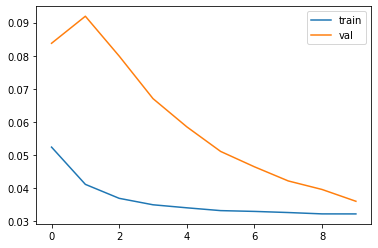

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.show()

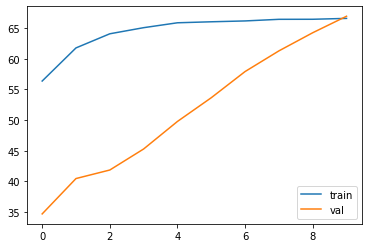

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.legend(['train', 'val'])
plt.show()